Objective: Predict the insurance charges (medical cost) based on attributes such as age, gender, BMI, number of children, smoker status, and region.

In [1]:

import kagglehub
path = kagglehub.dataset_download("rahulvyasm/medical-insurance-cost-prediction")

print("Path to dataset files:", path)



100%|██████████| 31.6k/31.6k [00:00<00:00, 48.0MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/rahulvyasm/medical-insurance-cost-prediction/versions/1


In [2]:
import pandas as pd
import os
csv_file = os.path.join(path, "medical_insurance.csv")
df = pd.read_csv(csv_file)
df.head()


,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [3]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2772 entries, 0 to 2771
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       2772 non-null   int64  
 1   sex       2772 non-null   object 
 2   bmi       2772 non-null   float64
 3   children  2772 non-null   int64  
 4   smoker    2772 non-null   object 
 5   region    2772 non-null   object 
 6   charges   2772 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 151.7+ KB


In [4]:
df.describe()

,age,bmi,children,charges
count,2772.000000,2772.000000,2772.000000,2772.000000
mean,39.109668,30.701349,1.101732,13261.369959
std,14.081459,6.129449,1.214806,12151.768945
min,18.000000,15.960000,0.000000,1121.873900
25%,26.000000,26.220000,0.000000,4687.797000
50%,39.000000,30.447500,1.000000,9333.014350
75%,51.000000,34.770000,2.000000,16577.779500
max,64.000000,53.130000,5.000000,63770.428010


In [5]:
df.isnull().sum()

,0
age,0
sex,0
bmi,0
children,0
smoker,0
region,0
charges,0


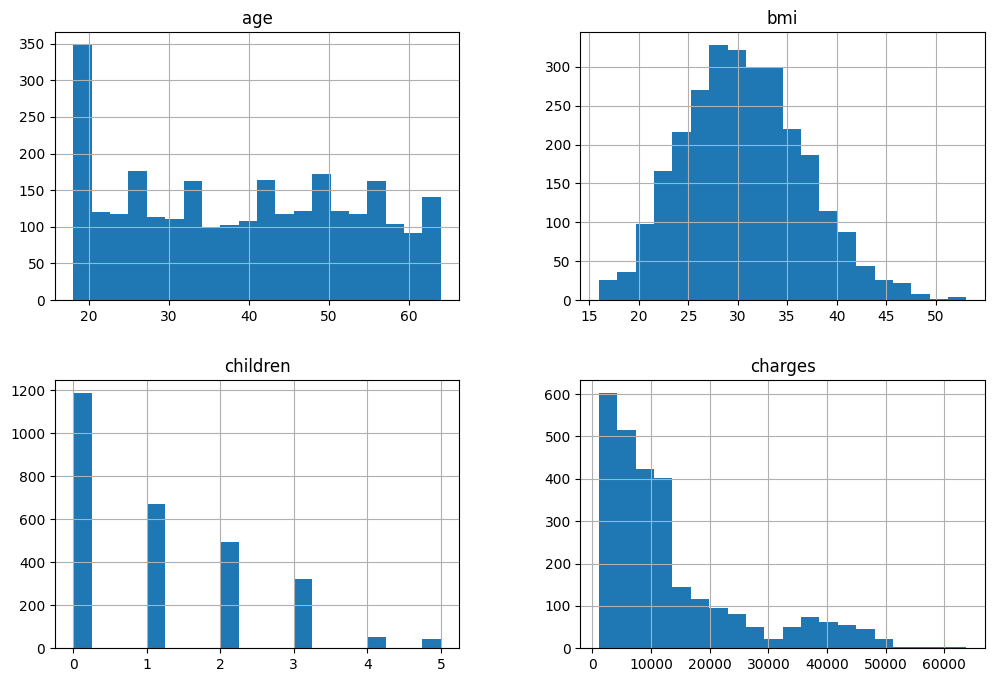

In [6]:
#Univariate analysis
import matplotlib.pyplot as plt
import seaborn as sns
#histogram
numeric_cols = ['age','bmi','children','charges']
df[numeric_cols].hist(figsize=(12,8), bins=20)
plt.show()


Overall summary:

Age: fairly even spread

BMI: roughly normal

Children: right-skewed

Charges: highly right-skewed

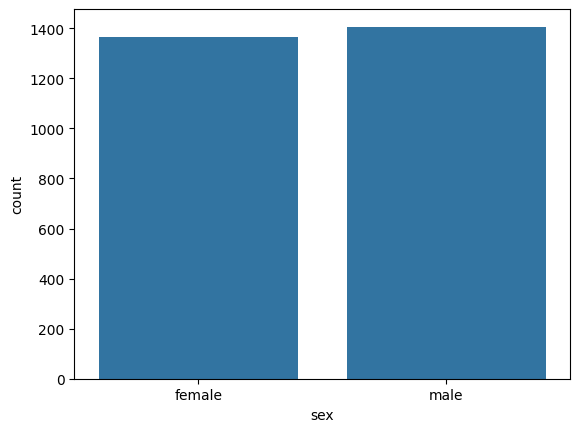

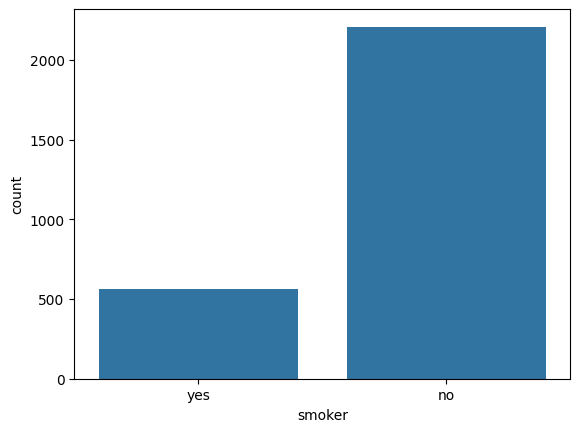

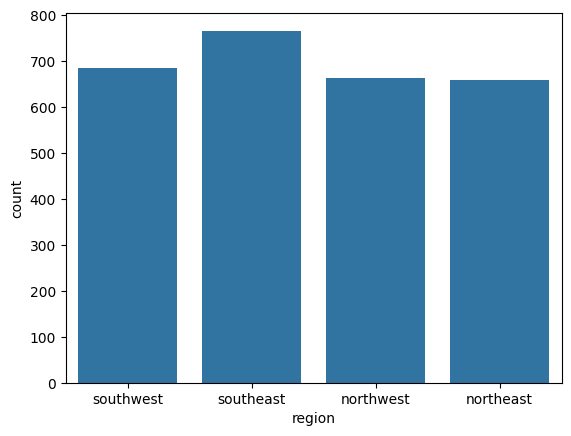

In [7]:
categorical_cols = ['sex', 'smoker', 'region']

for col in categorical_cols:
    sns.countplot(data=df, x=col)
    plt.show()


distribution of male and female are almost similar
distribution of smoker is uneven smokers are very less compared to non smokers
distribution of region of southwest, northwest,northeast are same and southeast is a little higher

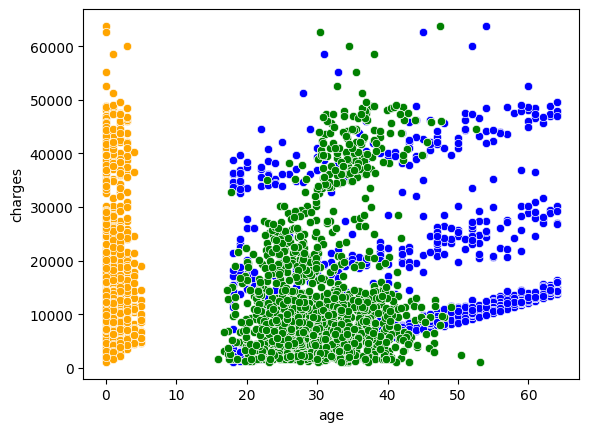

In [8]:
#Bivariate

# Scatter plots
sns.scatterplot(data=df, x='age', y='charges',color='blue')
sns.scatterplot(data=df, x='bmi', y='charges',color='green')
sns.scatterplot(data=df, x='children', y='charges',color='orange')
plt.show()


Age and BMI have some impact on charges.

Children show little influence.

A few very high charge outliers exist (as seen earlier from right-skewed distribution)


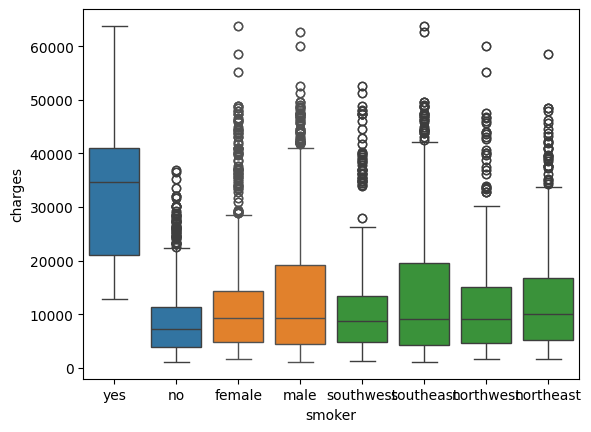

In [9]:
# Box plots
sns.boxplot(data=df, x='smoker', y='charges')
sns.boxplot(data=df, x='sex', y='charges')
sns.boxplot(data=df, x='region', y='charges')
plt.show()


Smoking is the most important driver of high medical charges.

Age and BMI show moderate positive effects.

Children, sex, and region have little impact.

There are some high-cost outliers, consistent with the earlier right-skewed charges distribution.

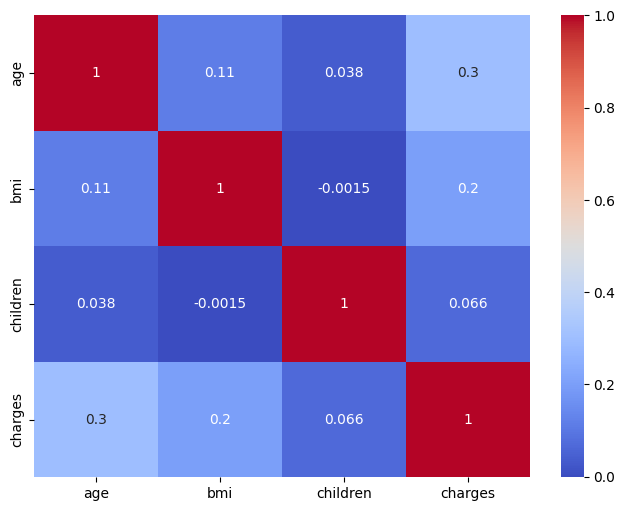

In [10]:
# Correlation matrix b/w numeric values
plt.figure(figsize=(8,6))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.show()

In summary, age appears to be the strongest linear predictor of charges among these variables, showing the highest correlation coefficient ($0.3$) with it.

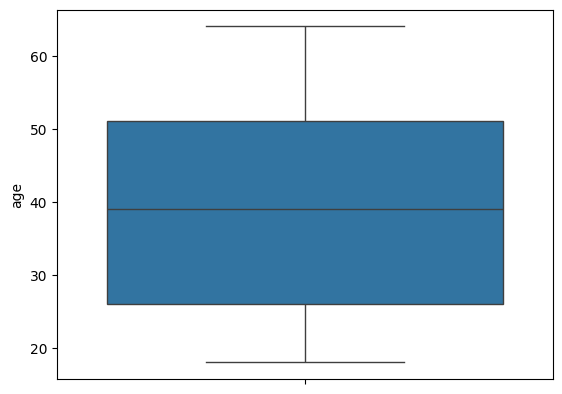

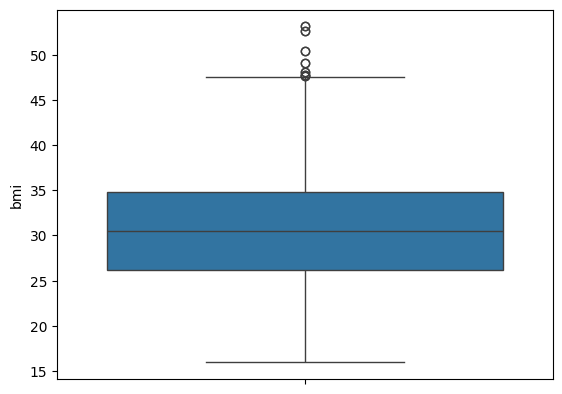

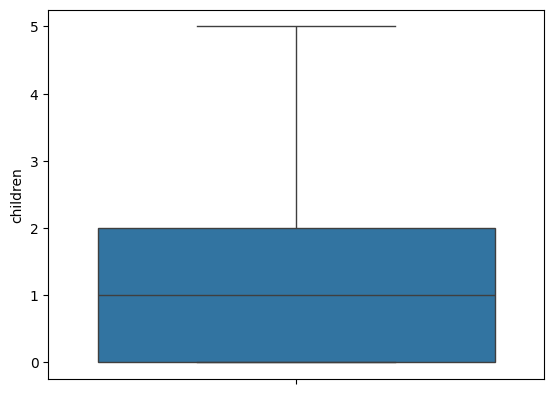

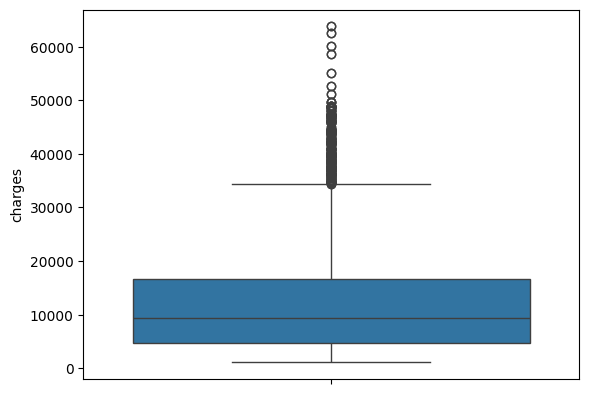

In [11]:
#Check Outliers
for col in numeric_cols:
    sns.boxplot(df[col])
    plt.show()

In [12]:
import numpy as np
# Log-transform charges
df['log_charges'] = np.log1p(df['charges'])
Q1 = df['bmi'].quantile(0.25)
Q3 = df['bmi'].quantile(0.75)
IQR = Q3 - Q1

lower = Q1 - 1.5*IQR
upper = Q3 + 1.5*IQR

df['bmi'] = np.where(df['bmi'] > upper, upper,
                     np.where(df['bmi'] < lower, lower, df['bmi']))


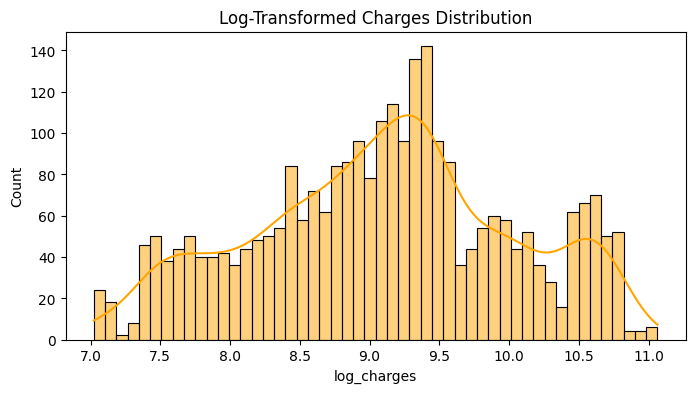

In [13]:
plt.figure(figsize=(8,4))
sns.histplot(df['log_charges'], bins=50, kde=True, color='orange')
plt.title("Log-Transformed Charges Distribution")
plt.show()


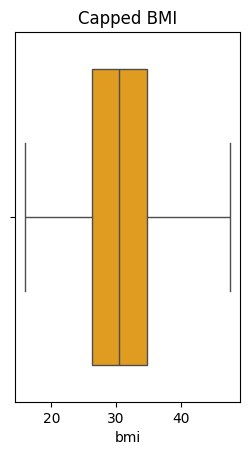

In [14]:
plt.subplot(1,2,2)
sns.boxplot(x=df['bmi'], color='orange')
plt.title("Capped BMI")
plt.show()


In [15]:
#Feature Encoding

In [16]:
numeric_features = ['age', 'bmi', 'children']
categorical_features = ['sex', 'smoker', 'region']
target = 'log_charges'


In [17]:
#CAtegorical encoding
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

for col in ['sex', 'smoker']:
    df[col+'_enc'] = le.fit_transform(df[col])


In [18]:
#Feature Set for Regression
feature_cols = numeric_features + ['sex_enc', 'smoker_enc'] + \
               [col for col in df.columns if 'region_' in col]

X = df[feature_cols]
y = df[target]

print("Features for model:")
print(X.head())


Features for model:
   age     bmi  children  sex_enc  smoker_enc
0   19  27.900         0        0           1
1   18  33.770         1        1           0
2   28  33.000         3        1           0
3   33  22.705         0        1           0
4   32  28.880         0        1           0


In [19]:
# train-test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)


Train shape: (2217, 5)
Test shape: (555, 5)


In [20]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [21]:
#Linear Regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
# Initialize model
lr = LinearRegression()

# Fit on training data
lr.fit(X_train_scaled, y_train)

# Predict on test set
y_pred_lr = lr.predict(X_test_scaled)

# Evaluate
print("Linear Regression Metrics:")
print("R²:", r2_score(y_test, y_pred_lr))
print("MAE:", mean_absolute_error(y_test, y_pred_lr))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_lr)))

Linear Regression Metrics:
R²: 0.7423692168261165
MAE: 0.31065675464124626
RMSE: 0.4920031220711883


In [22]:
#RIDGE Regression
from sklearn.linear_model import Ridge

ridge = Ridge(alpha=1.0)
ridge.fit(X_train_scaled, y_train)
y_pred_ridge = ridge.predict(X_test_scaled)

print("\nRidge Regression Metrics:")
print("R²:", r2_score(y_test, y_pred_ridge))
print("MAE:", mean_absolute_error(y_test, y_pred_ridge))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_ridge)))


Ridge Regression Metrics:
R²: 0.7423572839086375
MAE: 0.31073511222289424
RMSE: 0.49201451621555414


In [23]:
#LASSO REGRESSION
from sklearn.linear_model import Lasso

lasso = Lasso(alpha=0.01)  # alpha = regularization strength
lasso.fit(X_train_scaled, y_train)
y_pred_lasso = lasso.predict(X_test_scaled)

print("\nLasso Regression Metrics:")
print("R²:", r2_score(y_test, y_pred_lasso))
print("MAE:", mean_absolute_error(y_test, y_pred_lasso))
print("RMSE:", mean_squared_error(y_test, y_pred_lasso))



Lasso Regression Metrics:
R²: 0.7401097281401443
MAE: 0.31116705259288313
RMSE: 0.24419006303742724


In [24]:
# Random Forest
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)  # Random Forest does not require scaling
y_pred_rf = rf.predict(X_test)

print("\nRandom Forest Metrics:")
print("R²:", r2_score(y_test, y_pred_rf))
print("MAE:", mean_absolute_error(y_test, y_pred_rf))
print("RMSE:", mean_squared_error(y_test, y_pred_rf))



Random Forest Metrics:
R²: 0.9188110719121841
MAE: 0.12221789297713045
RMSE: 0.07628423074795077


In [25]:
#COMPARE MODELS
import pandas as pd

results = pd.DataFrame({
    'Model': ['Linear', 'Ridge', 'Lasso', 'Random Forest'],
    'R²': [
        r2_score(y_test, y_pred_lr),
        r2_score(y_test, y_pred_ridge),
        r2_score(y_test, y_pred_lasso),
        r2_score(y_test, y_pred_rf)
    ],
    'MAE': [
        mean_absolute_error(y_test, y_pred_lr),
        mean_absolute_error(y_test, y_pred_ridge),
        mean_absolute_error(y_test, y_pred_lasso),
        mean_absolute_error(y_test, y_pred_rf)
    ],
    'RMSE': [
        np.sqrt(mean_squared_error(y_test, y_pred_lr)),
        np.sqrt(mean_squared_error(y_test, y_pred_ridge)),
        np.sqrt(mean_squared_error(y_test, y_pred_lasso)),
        np.sqrt(mean_squared_error(y_test, y_pred_rf))
    ]
})

results

,Model,R²,MAE,RMSE
0,Linear,0.742369,0.310657,0.492003
1,Ridge,0.742357,0.310735,0.492015
2,Lasso,0.740110,0.311167,0.494156
3,Random Forest,0.918811,0.122218,0.276196


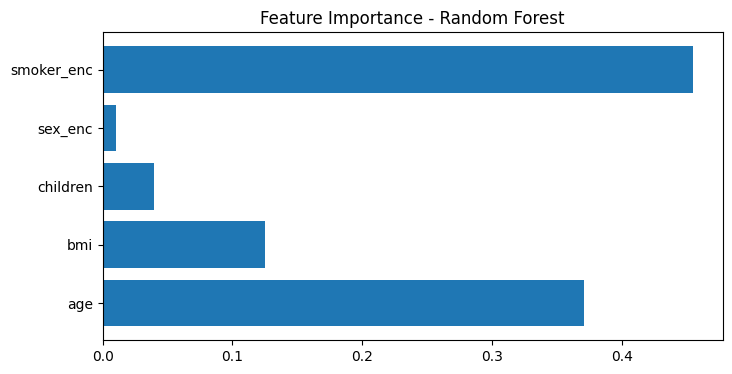

In [26]:
import matplotlib.pyplot as plt

# For Random Forest
importances = rf.feature_importances_
features = X_train.columns

plt.figure(figsize=(8,4))
plt.barh(features, importances)
plt.title("Feature Importance - Random Forest")
plt.show()


Age has the strongest positive correlation with charges ($r = 0.3$).The correlations between bmi, children, and charges are weaker

smoker_enc (Smoker Status) is the most important feature by a significant margin (importance $\approx 0.5$)
Age is the second most important feature (importance $\approx 0.36$).sex_enc (Gender) is the least important feature

Age has a fairly even distribution and shows a moderate positive correlation with charges (r ≈ 0.3).

BMI is roughly normal and has a moderate effect on medical charges.

Number of children is right-skewed and has little influence on charges.

Medical charges are highly right-skewed, with a few extreme outliers representing very high costs.

Sex distribution is nearly equal; gender has minimal impact on charges.

Smoker distribution is uneven; smokers are fewer but contribute significantly higher charges.

Region distribution is mostly balanced, with the southeast slightly higher; region has minimal effect on charges.

Smoking status is the most important predictor of charges (feature importance ≈ 0.5).

Age is the second most important predictor (feature importance ≈ 0.36).

BMI shows moderate influence; children, sex, and region contribute very little.

High-cost outliers align with the right-skewed distribution of charges.

Overall, smoking is the dominant factor, with age and BMI having moderate positive effects, while other features have negligible impact.
